# Construct Budget Plots

A Budget plot was constructed for the analysis of the carbon dioxide (CO2) consuming and producing reactions in the Bundle Sheat cell in the previously constructed Maize C4 model

## Imports

In [1]:
from cobra.io import read_sbml_model
from cobra import flux_analysis
import pandas as pd

## Reading the models and applying maintenance and Rubisco constrains

In [2]:
"""
Read and prepare C4 model
"""

c4_model = read_sbml_model("c4_model.xml")

c4_model.solver = "glpk"

c4_model.objective = '[B]_Maize_biomass_tx'


def c4_maintenance(c4_model):
    #Constrains for light dependent maintenance costs
    atp_b = c4_model.reactions.get_by_id("[B]_ATPase_tx")
    photon_b = c4_model.reactions.get_by_id("[B]_Photon_tx")
    atp_m = c4_model.reactions.get_by_id("[M]_ATPase_tx")
    photon_m = c4_model.reactions.get_by_id("[M]_Photon_tx")

    const_b = c4_model.problem.Constraint((0.0049 * photon_b.flux_expression + 2.7852) - atp_b.flux_expression , lb = 0, ub = 0)
    c4_model.add_cons_vars(const_b)

    const_m = c4_model.problem.Constraint((0.0049 * photon_m.flux_expression + 2.7852) - atp_m.flux_expression , lb = 0, ub = 0)
    c4_model.add_cons_vars(const_m)
    # ATP/NADPH 3:1 constraints
    const = c4_model.problem.Constraint(c4_model.reactions.get_by_id("[B]_ATPase_tx").flux_expression -  3 * (c4_model.reactions.get_by_id("[B]_NADPHoxc_tx").flux_expression + c4_model.reactions.get_by_id("[B]_NADPHoxp_tx").flux_expression + c4_model.reactions.get_by_id("[B]_NADPHoxm_tx").flux_expression) , lb = 0, ub = 0)
    c4_model.add_cons_vars(const)

    const = c4_model.problem.Constraint(c4_model.reactions.get_by_id("[M]_ATPase_tx").flux_expression -  3 * (c4_model.reactions.get_by_id("[M]_NADPHoxc_tx").flux_expression + c4_model.reactions.get_by_id("[M]_NADPHoxp_tx").flux_expression + c4_model.reactions.get_by_id("[M]_NADPHoxm_tx").flux_expression) , lb = 0, ub = 0)
    c4_model.add_cons_vars(const)

#Add Light dependent maintenance
c4_maintenance(c4_model)

No objective coefficients in model. Unclear what should be optimized


## Using pFBA

In [3]:
"""
Function to perform the simulation: We will end with a pandas dataframe that we will use to construct the plots 
"""


def c4_simulation(light, N, c4_model):
    ##C4
    with c4_model:
        #Light Uptale constrain
        B_Im_hnu = c4_model.reactions.get_by_id("[B]_Photon_tx")
        M_Im_hnu = c4_model.reactions.get_by_id("[M]_Photon_tx")
        #CONSTRAINT: Total Photon uptake limited to "light" µE
        const_hnu_sum = c4_model.problem.Constraint( B_Im_hnu.flux_expression + M_Im_hnu.flux_expression,
                                                lb = 0, ub = light)
        c4_model.add_cons_vars(const_hnu_sum)
        #CONSTRAINT: Total Photon uptake by bundle sheath must be less or equal than in mesophyll
        const_hnu_ratio = c4_model.problem.Constraint( M_Im_hnu.flux_expression - B_Im_hnu.flux_expression,
                                                lb = 0, ub = light)
        c4_model.add_cons_vars(const_hnu_ratio)
        #CONSTRAINT : Total N uptake must not surpass defined upper bound
        m_n = c4_model.reactions.get_by_id("[B]_Nitrate_tx")
        bs_n = c4_model.reactions.get_by_id("[M]_Nitrate_tx")
        const_n_ratio = c4_model.problem.Constraint( bs_n.flux_expression + m_n.flux_expression,
                                               lb = 0, ub = N)
        c4_model.add_cons_vars(const_n_ratio)
        #FBA
        print(f'Maize C4 FBA: {c4_model.summary()}')
        #pFBA
        solution = flux_analysis.pfba(c4_model)
        sum_of_flux = solution.fluxes.abs().sum()
        solution_frame=solution.to_frame()
        return solution_frame

#Definig limiting constrains: max of 100 μmol "light" uptake and 0.2 μmol nitrogen uptake
solution_frame=c4_simulation(100, .2, c4_model)

Maize C4 FBA: Objective
1.0 [B]_Maize_biomass_tx = 0.00395616383377282

Uptake
------
           Metabolite           Reaction     Flux  C-Number C-Flux
        [B]_NITRATE_e     [B]_Nitrate_tx  0.03629         0  0.00%
         [B]_Photon_e      [B]_Photon_tx    22.54         0  0.00%
             [B]_Pi_e          [B]_Pi_tx 0.004315         0  0.00%
         [B]_PROTON_c  [B]_unlProtHYPO_c    6.311         0  0.00%
 [M]_CARBON_DIOXIDE_e         [M]_CO2_tx    2.915         0  0.00%
          [M]_WATER_e         [M]_H2O_tx    2.608         0  0.00%
        [M]_NITRATE_e     [M]_Nitrate_tx   0.1637         0  0.00%
         [M]_Photon_e      [M]_Photon_tx    22.54         0  0.00%
        [M]_SULFATE_e         [M]_SO4_tx  0.00571         0  0.00%
         [M]_PROTON_c  [M]_unlProtHYPO_c   0.6647         0  0.00%

Secretion
---------
            Metabolite   Reaction   Flux  C-Number C-Flux
 [B]_OXYGEN_MOLECULE_e  [B]_O2_tx -1.454         0  0.00%
 [M]_OXYGEN_MOLECULE_e  [M]_O2_tx -1.983

## Preparing data and plotting

For the presented Budget plot we searched for CO2 consuming and producing reactions in the BS cell in the C4 model. Following this logic, transport reactions of CO2 were not considered, and so we expect the flux through consuming reactions to be equal to producing reactions.

In [4]:
#Defining the list of metabolites to search
budget_metabolites = []

#Defining the compartments within the model
compartment = ["_c", "_m", "_p", "_x", "_e", "tx"]

#Searching for the metabolites in the model - Searching for CO2 in the BS cell
for met in c4_model.metabolites.query("CARBON_DIOXIDE_"):
    if met.id[:3] == "[B]":
        budget_metabolites.append(met)

budget_metabolites

[<Metabolite [B]_CARBON_DIOXIDE_x at 0x2a25160f1c8>,
 <Metabolite [B]_CARBON_DIOXIDE_p at 0x2a25160f748>,
 <Metabolite [B]_CARBON_DIOXIDE_m at 0x2a25160f948>,
 <Metabolite [B]_CARBON_DIOXIDE_e at 0x2a251615308>,
 <Metabolite [B]_CARBON_DIOXIDE_c at 0x2a251615408>]

In [5]:
"""
Define consuming and producing reactions
"""

#Defining list of reactions producing and consuming the metabolite
consumers = []
producers = []

#Add reactions to respective list and exclude transport reactions
for met in budget_metabolites:
    for reaction in c4_model.reactions:
        if met in reaction.reactants and reaction.id[-2:] in compartment:
            consumers.append(reaction.id)
        elif met in reaction.products and reaction.id[-2:] in compartment:
            producers.append(reaction.id)

In [6]:
"""
Correct consumption/production with regards to directionality
"""

#Get flux values from the simulation for metabolite consuming/producing reactions
producers_df = solution_frame.loc[producers,:]
consumers_df = solution_frame.loc[consumers,:]

#Get values with negative flows: producing reactions with negative flow are consuming and vice-versa
negative_producers = list(producers_df[producers_df["fluxes"] < 0].index)
negative_consumers = list(consumers_df[consumers_df["fluxes"] < 0].index)


#Add reactions to correct list
consumers.extend(negative_producers)
producers.extend(negative_consumers)

#Remove reactions with negative flux from old list
def remove_items(test_list, item):
    res = [i for i in test_list if i != item]
    return res

for item in negative_producers:
    producers = remove_items(producers, item)

for item in negative_consumers:
    consumers = remove_items(consumers, item)

In [7]:
"""
Get producing reactions and fluxes
"""

#Get flux values from the simulation for metabolite consuming/producing reactions (correct list)
producers_df = solution_frame.loc[producers,:]
#Make all values positive (disregard directionality)
producers_df["fluxes"] = producers_df["fluxes"].abs()
#Remove reactions with zero flux
producers_df = producers_df[(producers_df.T != 0).all()]
producers_df

,fluxes,reduced_costs
[B]_DIAMINOPIMDECARB_RXN_p,0.006534,-2.0
[B]_IGPSYN_RXN_p,0.001098,-2.0
[B]_ACETOOHBUTSYN_RXN_p,0.006424,-2.0
[B]_MALIC_NADP_RXN_p,2.715096,-2.0
[B]_RXN_7800_p,0.013232,-2.0
[B]_ACETOLACTSYN_RXN_p,0.024378,-2.0
[B]_PREPHENATE_DEHYDROGENASE_NADP_RXN_p,0.002635,-2.0
[B]_OROTPDECARB_RXN_p,0.000752,-2.0
[B]_CARBOXYCYCLOHEXADIENYL_DEHYDRATASE_RXN_p,0.004392,-2.0
[B]_ISOCITRATE_DEHYDROGENASE_NAD_RXN_m,0.023230,-2.0


In [8]:
"""
Get consuming reactions and fluxes
"""

#Get flux values from the simulation for metabolite consuming/producing reactions (correct list)
consumers_df = solution_frame.loc[consumers,:]
#Make all values positive (disregard directionality)
consumers_df["fluxes"]  = consumers_df["fluxes"].abs()
#Remove reactions with zero flux
consumers_df = consumers_df[(consumers_df.T != 0).all()]
consumers_df


,fluxes,reduced_costs
[B]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p,2.887073,-2.0
[B]_RXN0_5224_p,0.000472,-2.0


In [9]:
"""
Fluxes in consumption and production should be equal
"""

#Sum the flux values
print("Sum of consumer fluxes: {}".format(consumers_df ["fluxes"].sum(axis=0)))
print("Sum of producer fluxes: {}".format(producers_df ["fluxes"].sum(axis=0)))

Sum of consumer fluxes: 2.887545391905673
Sum of producer fluxes: 2.887545391905673


As expected, the sum of the fluxes of the CO2 consuming reactions is equal to the sum of CO2 producing reactions in the bundle sheat cell.

In [10]:
"""
Concatenate producer and consumer dataframes
"""

producers_df["Status"] = "Producer"
consumers_df["Status"] = "Consumer"

frame = [producers_df, consumers_df]

all_reactions = pd.concat(frame)

all_reactions["label"] = all_reactions.index

all_reactions

,fluxes,reduced_costs,Status,label
[B]_DIAMINOPIMDECARB_RXN_p,0.006534,-2.0,Producer,[B]_DIAMINOPIMDECARB_RXN_p
[B]_IGPSYN_RXN_p,0.001098,-2.0,Producer,[B]_IGPSYN_RXN_p
[B]_ACETOOHBUTSYN_RXN_p,0.006424,-2.0,Producer,[B]_ACETOOHBUTSYN_RXN_p
[B]_MALIC_NADP_RXN_p,2.715096,-2.0,Producer,[B]_MALIC_NADP_RXN_p
[B]_RXN_7800_p,0.013232,-2.0,Producer,[B]_RXN_7800_p
[B]_ACETOLACTSYN_RXN_p,0.024378,-2.0,Producer,[B]_ACETOLACTSYN_RXN_p
[B]_PREPHENATE_DEHYDROGENASE_NADP_RXN_p,0.002635,-2.0,Producer,[B]_PREPHENATE_DEHYDROGENASE_NADP_RXN_p
[B]_OROTPDECARB_RXN_p,0.000752,-2.0,Producer,[B]_OROTPDECARB_RXN_p
[B]_CARBOXYCYCLOHEXADIENYL_DEHYDRATASE_RXN_p,0.004392,-2.0,Producer,[B]_CARBOXYCYCLOHEXADIENYL_DEHYDRATASE_RXN_p
[B]_ISOCITRATE_DEHYDROGENASE_NAD_RXN_m,0.023230,-2.0,Producer,[B]_ISOCITRATE_DEHYDROGENASE_NAD_RXN_m


In [11]:
"""
Pick the colors - using random for color selection and using set.seed for reproducibility
"""

import random
import matplotlib.pyplot as plt


#Defining the nº of colors
number_of_colors = len(all_reactions.index)

#Getting a list of colors
random.seed(177)
color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]

#Getting list of reactions
reaction_list = list(all_reactions.index)

#Build color dictionary
color_dict = {}
for i in range(len(reaction_list)):
    color_dict[reaction_list[i]] = color[i]



label,[B]_ACETOLACTSYN_RXN_p,[B]_ACETOOHBUTSYN_RXN_p,[B]_CARBOXYCYCLOHEXADIENYL_DEHYDRATASE_RXN_p,[B]_DIAMINOPIMDECARB_RXN_p,[B]_GCVMULTI_RXN_m,[B]_IGPSYN_RXN_p,[B]_ISOCITDEH_RXN_c,[B]_ISOCITDEH_RXN_m,[B]_ISOCITRATE_DEHYDROGENASE_NAD_RXN_m,[B]_MALIC_NADP_RXN_p,[B]_OROTPDECARB_RXN_p,[B]_PREPHENATE_DEHYDROGENASE_NADP_RXN_p,[B]_PYRUVDEH_RXN_m,[B]_RIBULOSE_BISPHOSPHATE_CARBOXYLASE_RXN_p,[B]_RXN0_5224_p,[B]_RXN_7800_p
Status,,,,,,,,,,,,,,,,
Consumer,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.887073,0.000472,NaN
Producer,0.024378,0.006424,0.004392,0.006534,0.053872,0.001098,0.004832,0.000269,0.02323,2.715096,0.000752,0.002635,0.030801,NaN,NaN,0.013232


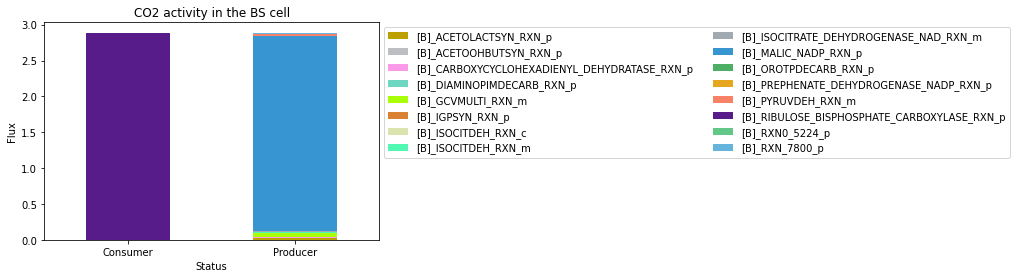

In [12]:
"""
Plot the pivot table and barplot
"""


chart = all_reactions.pivot_table(index="Status", columns="label", values="fluxes")
chart.plot.bar(rot = 0, stacked = True, legend = True, ylabel = "Flux", color = color_dict)
plt.legend(loc='best', bbox_to_anchor=(1.0, 0.5, 0.5, 0.5), ncol = 2)
plt.title("CO2 activity in the BS cell" )
figsize = [11, 14] #To prevent the cropping of the image
#plt.savefig('Budget_tests.svg', format='svg', bbox_inches = 'tight', dpi=600) #Line to save the image
chart




In the budget plot we can observe that the majority of CO2 in the bundle sheath cell is produced by the "MALIC_NADP_RXN_p" reaction, which is the NADP - malic enzyme reaction. This is the main decarboxylation pathway in C4 photosynthesis in maize, and we privelieged it other decarboxylation pathways in our approach. 

Consumption of CO2, as expected, occurs through the carboxylase activity of Rubisco, represented throught the "RIBULOSE_BIPHOSPHATE_CARBOXYLASE_RXN_p"